In [1]:
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
DAE_np_data_path = r'data\np\X4sShowX4StdOut.csv'

np_DAE_df = pd.read_csv(DAE_np_data_path)

In [4]:
# A dataset of 
np_DAE_df[np_DAE_df['author1'] != 'K.H.Hicks+'] # Dataset has multiple authors, we keep only B.K.Park+ to ensure only one target material...

,DatasetID,year1,author1,y:Value,y,dy,x1:ResEn,x1(eV),dx1(eV),x2:IncEn,...,Proj,Emiss,Prod1,MF,MT,ReacType,Quant1,nx,indVars,Reacode
205,13530002,1993,B.K.Park+,Data(B/SR/EV),2.332000e-07,6.086000e-08,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
206,13530002,1993,B.K.Park+,Data(B/SR/EV),1.133000e-07,4.229000e-08,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
207,13530002,1993,B.K.Park+,Data(B/SR/EV),8.373000e-08,3.650000e-08,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
208,13530002,1993,B.K.Park+,Data(B/SR/EV),0.000000e+00,0.000000e+00,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
209,13530002,1993,B.K.Park+,Data(B/SR/EV),3.774000e-07,7.774000e-08,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13552,13530013,1993,B.K.Park+,Data(B/SR/EV),6.241000e-07,1.777000e-07,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
13553,13530013,1993,B.K.Park+,Data(B/SR/EV),7.420000e-07,1.948000e-07,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
13554,13530013,1993,B.K.Park+,Data(B/SR/EV),6.237000e-07,1.786000e-07,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
13555,13530013,1993,B.K.Park+,Data(B/SR/EV),1.247000e-06,2.536000e-07,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"


In [5]:
df = np_DAE_df[['x2(eV)', 'x3(eV)', 'x4(deg)','y', 'dy']]

df = df.rename(columns={
    'x2(eV)': 'E_inc',
    'x3(eV)': 'E_sec',
    'x4(deg)': 'theta',
    'y': 'ddcs',  # double differential cross section
    'dy': 'Errddcs'  # Error on double differential cross section --> Could use this to weigh the KL loss (IDEA)

})

# df['E_inc'] = df['E_inc'] / 1e6  # eV → MeV
# df['E_sec'] = df['E_sec'] / 1e6  # eV → MeV

# Drop rows with missing values
df = df.dropna(subset=['E_inc', 'E_sec', 'theta', 'ddcs'])



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Unique sorted angles
unique_thetas = np.sort(df['theta'].unique())
E_bins = np.linspace(df['E_sec'].min(), df['E_sec'].max(), 100)

# Create a 2D array of shape (n_theta, n_E_bins)
heatmap = np.zeros((len(unique_thetas), len(E_bins) - 1))

# Fill in the heatmap row-by-row
for i, theta in enumerate(unique_thetas):
    subset = df[df['theta'] == theta]
    hist, _ = np.histogram(
        subset['E_sec'], bins=E_bins,
        weights=subset['ddcs']
    )
    heatmap[i] = hist

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
E_centers = 0.5 * (E_bins[:-1] + E_bins[1:])
pcm = ax.pcolormesh(E_centers, unique_thetas, heatmap, shading='auto', cmap='viridis')
fig.colorbar(pcm, ax=ax, label='ddcs [mb/sr/MeV]')
ax.set_xlabel('E_sec [MeV]')
ax.set_ylabel('Theta [deg]')
ax.set_title('Experimental DDCS (sparse angle coverage)')
plt.tight_layout()
plt.show()


In [55]:
print(np.sort(df['theta'].unique()))

[ 1  2  3  5  7  9 11 13]


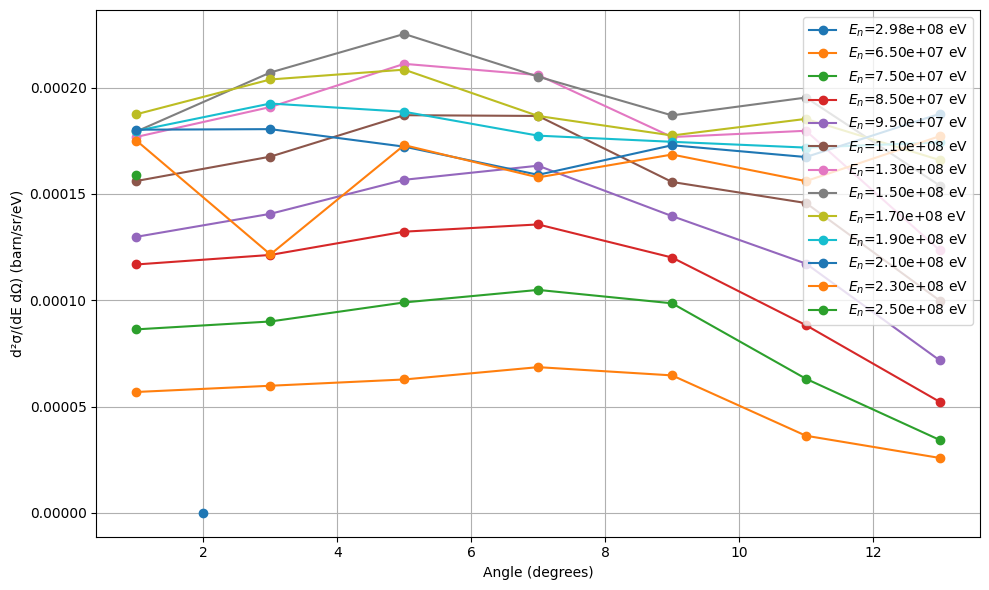

In [10]:
angle_max = np.max(df['theta'].unique())
unique_angles = np.sort(df['theta'].unique())

# energies_to_plot = np.linspace(df['E_inc'].min(), df['E_inc'].max(), 10)  # 10 evenly spaced energies
energies_to_plot = df['E_inc'].unique()
tolerance = 0.05  # MeV

plt.figure(figsize=(10, 6))

for E_n in energies_to_plot:
    if E_n in (65,298):
        continue
    
    df_slice = df[np.abs(df['E_inc'] - E_n) < tolerance] 
    if df_slice.empty:
        continue
    
    # grouped = df_slice.groupby('theta')['ddcs'].sum()
    # # Align grouped with full angle range
    # y_vals = np.array([grouped.get(angle) for angle in unique_angles])
    
    # plt.plot(unique_angles, y_vals, marker='o', label=rf"$E_n$={E_n:.2f} MeV")
    grouped = df_slice.groupby('theta')['ddcs'].sum()
    angles_present = grouped.index.to_numpy()
    y_vals = grouped.to_numpy()

    plt.plot(angles_present, y_vals, marker='o', label=rf"$E_n$={E_n:.2e} eV")

plt.xlabel("Angle (degrees)")
plt.ylabel("d²σ/(dE dΩ) (barn/sr/eV)")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')  # optional log scale for better visibility
plt.show()


In [24]:
# Group data by angle
grouped = df.groupby('theta')

# Store results here
dsigma_dOmega = []

for angle, group in grouped:
    # Sort by energy to ensure correct integration
    group_sorted = group.sort_values('E_sec')

    # Numerical integration using the trapezoidal rule
    integral = np.trapezoid(group_sorted['ddcs'], group_sorted['E_sec'])

    dsigma_dOmega.append({'theta': angle, 'dsigma_dOmega': integral})

# Create final DataFrame
df_result = pd.DataFrame(dsigma_dOmega)

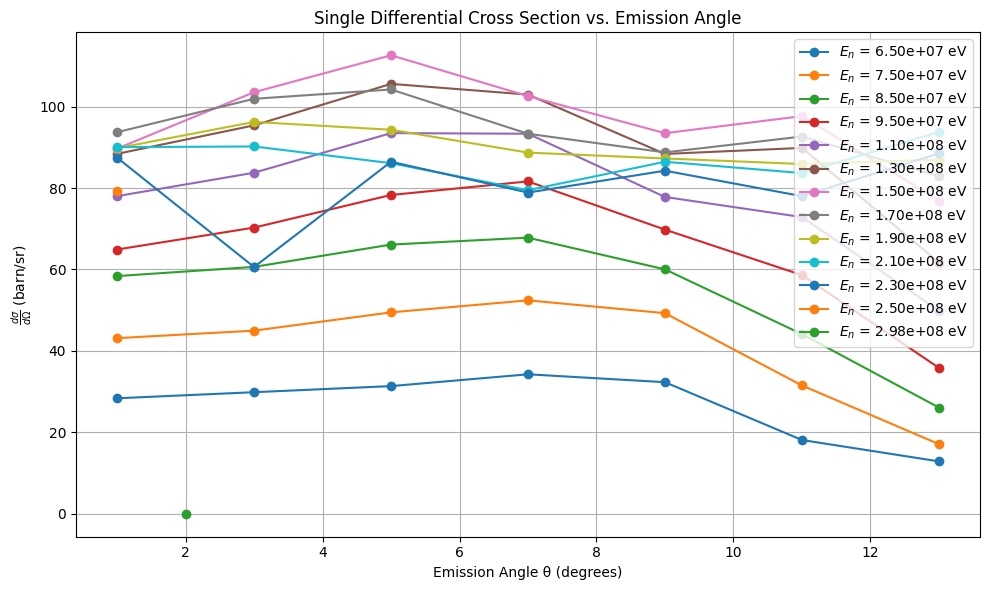

In [11]:
# Get sorted unique incident energies and angles
energies_to_plot = np.sort(df['E_inc'].unique())
unique_angles = np.sort(df['theta'].unique())
tolerance = 0.05  # MeV

plt.figure(figsize=(10, 6))

for E_n in energies_to_plot:
    if E_n in (65, 298):  # skipping unwanted energies
        continue

    # Select data near the current incident energy
    df_slice = df[np.abs(df['E_inc'] - E_n) < tolerance]
    if df_slice.empty:
        continue

    # Group by angle and integrate DDCS over E_sec
    dsigma_dOmega_vals = []
    angles_present = []

    for angle, group in df_slice.groupby('theta'):
        # Sort by emitted proton energy
        group_sorted = group.sort_values('E_sec')
        # Perform numerical integration over E_sec
        integral = np.trapezoid(group_sorted['ddcs'], group_sorted['E_sec'])
        dsigma_dOmega_vals.append(integral)
        angles_present.append(angle)

    # Plot dsigma/dOmega vs angle
    plt.plot(angles_present, dsigma_dOmega_vals, marker='o', label=rf"$E_n$ = {E_n:.2e} eV")

plt.xlabel("Emission Angle θ (degrees)")
plt.ylabel(r"$\frac{d\sigma}{d\Omega}$ (barn/sr)")
plt.title("Single Differential Cross Section vs. Emission Angle")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')  # optional
plt.show()

In [ ]:
def simulate_ddcs(random_tensor, E_n_lab, N_theta_bins, N_E_bins=100):
    """
    Simulates DDCS for the reaction 32S(n,p)32P.
    
    Parameters:
        random_tensor (torch.Tensor): 1D tensor of uniform random numbers in [0, 1], length N_samples
        E_n_lab (float): Incident neutron energy in MeV (lab frame)
        N_theta_bins (int): Number of angular bins (0-180 deg)
        N_E_bins (int): Number of energy bins for emitted proton
    
    Returns:
        ddcs (torch.Tensor): 2D histogram [theta_bin, energy_bin]
        theta_edges (torch.Tensor), E_edges (torch.Tensor): Bin edges
    """
    assert random_tensor.ndim == 1, "Input must be 1D tensor"
    device = random_tensor.device
    dtype = random_tensor.dtype
    N_samples = len(random_tensor)

    # Atomic masses (u), converted to MeV
    u_to_MeV = torch.tensor(931.494, device=device, dtype=dtype)
    m_n = torch.tensor(1.008664, device=device, dtype=dtype) * u_to_MeV
    m_p = torch.tensor(1.007276, device=device, dtype=dtype) * u_to_MeV
    m_S = torch.tensor(31.972071, device=device, dtype=dtype) * u_to_MeV
    m_P = torch.tensor(31.973907, device=device, dtype=dtype) * u_to_MeV

    Q = (m_S + m_n - m_P - m_p)  # Q-value in MeV

    # Sample angles isotropically in CM frame
    cos_theta_cm = 2 * random_tensor - 1
    theta_cm_rad = torch.acos(cos_theta_cm)  # in radians
    theta_deg = torch.rad2deg(theta_cm_rad)

    # Reduced mass of initial system
    M_tot = m_n + m_S
    mu_in = (m_n * m_S) / M_tot

    # CM energy
    E_cm = mu_in * E_n_lab / m_n

    # Available energy in CM
    E_available = E_cm + Q

    # Reduced mass of final system
    mu_out = (m_p * m_P) / (m_p + m_P)

    # CM momentum of outgoing proton
    p_cm = torch.sqrt(2 * mu_out * E_available)

    # Velocity of CM
    v_cm = m_n * torch.sqrt(2 * E_n_lab / m_n) / M_tot

    # Proton velocity in CM frame
    v_p_cm = p_cm / m_p

    # Compute lab-frame proton energy
    E_p_lab = 0.5 * m_p * (v_p_cm**2 + v_cm**2 + 2 * v_p_cm * v_cm * cos_theta_cm)
    E_p_lab = E_p_lab / u_to_MeV  # Convert to MeV

    # Bin the results into (theta, E_p) histogram
    theta_bins = torch.linspace(0, N_theta_bins, N_theta_bins + 1, device=device, dtype=dtype)
    E_bins = torch.linspace(0, torch.max(E_p_lab)*1.05, N_E_bins + 1, device=device, dtype=dtype)

    # Create 2D histogram using PyTorch
    theta_indices = torch.bucketize(theta_deg, theta_bins) - 1
    E_indices = torch.bucketize(E_p_lab, E_bins) - 1
    
    # Filter out out-of-bounds values
    mask = (theta_indices >= 0) & (theta_indices < N_theta_bins) & \
           (E_indices >= 0) & (E_indices < N_E_bins)
    theta_indices = theta_indices[mask]
    E_indices = E_indices[mask]
    
    # Create 2D histogram
    ddcs = torch.zeros((N_theta_bins, N_E_bins), device=device, dtype=dtype)
    ddcs.index_put_((theta_indices, E_indices), torch.ones_like(theta_indices, dtype=dtype), accumulate=True)

    # Normalize to probability density
    ddcs = ddcs / ddcs.sum()

    return ddcs, theta_bins, E_bins


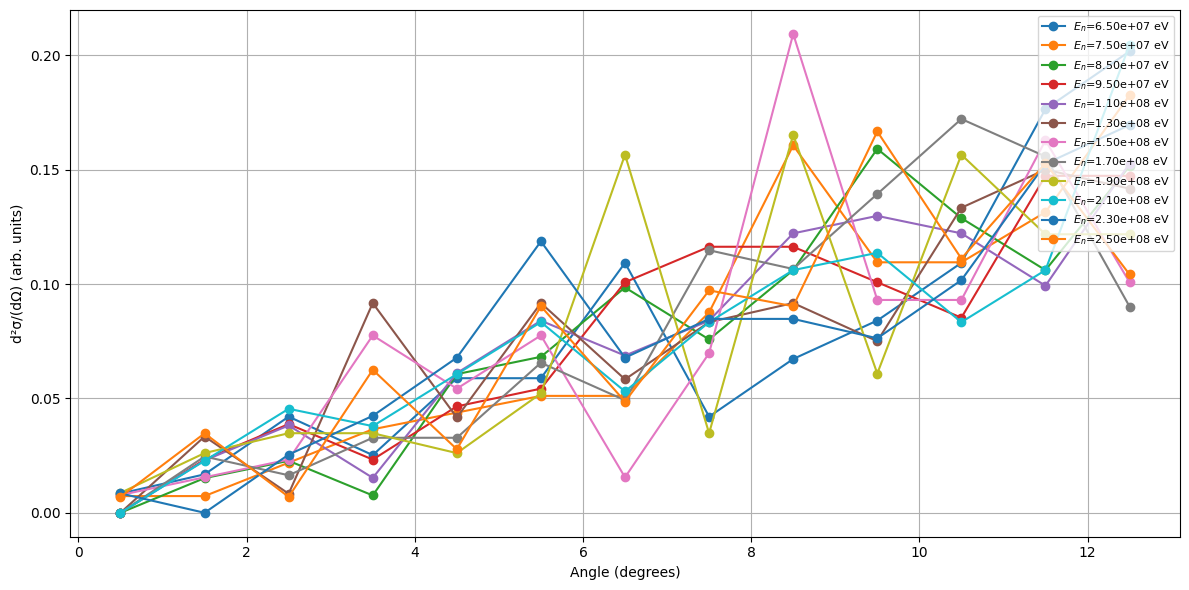

In [75]:
# Simulation neutron energies to match your experiment
energies_to_plot = [6.5e7, 7.5e7, 8.5e7, 9.5e7, 1.1e8, 1.3e8, 1.5e8, 1.7e8, 1.9e8, 2.1e8, 2.3e8, 2.5e8]  # eV
energies_to_plot = [E / 1e6 for E in energies_to_plot]  # convert to MeV

plt.figure(figsize=(12, 6))

for E_n in energies_to_plot:
    # Generate a batch of random samples for simulation
    rand_samples = torch.rand(1_000_0)
    
    # Run simulation for given E_n
    ddcs, theta_edges, E_edges = simulate_ddcs(rand_samples, N_theta_bins=13, E_n_lab=E_n)
    
    # Sum over energy to mimic experimental grouping: DDCS vs angle
    theta_centers = 0.5 * (theta_edges[:-1] + theta_edges[1:])
    ddcs_vs_angle = ddcs.sum(axis=1)  # sum over energy axis

    # Plot
    plt.plot(theta_centers, ddcs_vs_angle, marker='o', label=rf"$E_n$={E_n*1e6:.2e} eV")

plt.xlabel("Angle (degrees)")
plt.ylabel(r"d²σ/(dΩ) (arb. units)")
plt.legend(loc='upper right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()
